In [1]:
#행렬처리 모듈
import numpy as np
#자료구조인 Series, DataFrame 등을 제공하는 모듈
import pandas as pd
#추세 그래프 및 통계용 차트를 제공하는 시각화 모듈
import seaborn as sns
#그래프 및 시각화 모듈
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn import linear_model
from sklearn.preprocessing import scale, robust_scale, minmax_scale
#다중공선성 패키지 불러오기
from statsmodels.stats.outliers_influence import variance_inflation_factor
#sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.linear_model import LinearRegression
#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
#평가 함수
from sklearn import metrics
#os: 환겨설정 패키지
import os 

In [4]:
#1. 분석에 필요한 데이터 구성하기
ds_tele = pd.read_csv("../../실습화일/통신고객이탈.csv", engine="python")
ds_tel = ds_tele.copy()
ds_tel.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [5]:
#2. 데이터 전처리 - 결측치 처리
ds_tel.isnull().sum(axis = 0)
# 결측치가 없음
ds_tel["CHURN"].replace(to_replace="Active", value=0, inplace = True)
ds_tel["CHURN"].replace(to_replace="Churned", value=1, inplace = True)


In [6]:
#2. 데이터 전처리 - 데이터 분할
#random seed 고정 -> 매번 실행 시 같은 값을 얻음
np.random.seed(seed = 1234)
#0.7(70%) 보다 작으면 True -> train 데이터, 아니면 False -> test데이터
msk = np.random.rand(ds_tel.shape[0],) < 0.7
ds_tel_train = ds_tel[msk]
ds_tel_test = ds_tel[~msk]
#train 데이터와 test 데이터 크기
print("train data size : {}".format(ds_tel_train.shape))
print("test data size : {}".format(ds_tel_test.shape))

train data size : (635, 15)
test data size : (295, 15)


In [7]:
#train 데이터에 상수 추가
ds_tel_train = sm.add_constant(ds_tel_train)
ds_tel_train.head()
#로지스틱 회귀모델 및 회귀계수 검토

,const,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,1.0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,1.0,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,1.0,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
5,1.0,0,K105530,M,51,CAT 100,S80,Med,49.43,3,289,486.6,1,31.8,427,903.3
6,1.0,0,K106210,F,30,CAT 100,ASAD170,Med,32.30,6,427,729.6,12,52.8,490,907.2


In [8]:

#from_formula 함수를 이용하여 변수 역할 지정
log_model = sm.Logit.from_formula("""CHURN ~ C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""", ds_tel_train)
#적합
log_result = log_model.fit(method= 'bfgs')
#결과 출력
print(log_result.summary())

         Current function value: 0.261293
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                           29
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                  0.4660
Time:                        18:37:14   Log-Likelihood:                -165.92
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 9.369e-45
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1342      2

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
#로지스틱 모델로 test 데이터 예측
y_pred = log_result.predict(ds_tel_test)
#0과 1의 값을 가진 class로 변환
y_pred_class = (y_pred  >0.5).astype(int)
#상위 5건 출력
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

In [10]:
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(ds_tel_test["CHURN"], y_pred_class)))

Accuracy:0.898


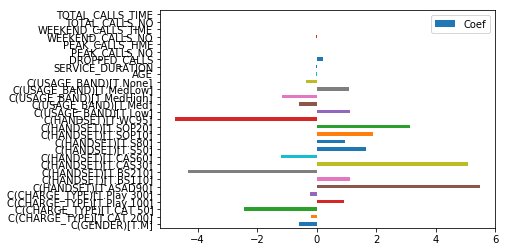

In [11]:
#설명변수 중요도
ds_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
ds_logistic_coef.plot.barh(y = "Coef")

In [12]:
#결론 도출
#select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
ds_tel_char = ds_tel.select_dtypes(include = "object")
ds_tel_numeric = ds_tel.select_dtypes(exclude = "object")
#Data Scale
ds_tel_char_train = ds_tel_char[msk]
ds_tel_numeric_scaled_train = scale(ds_tel_numeric[msk])
ds_tel_numeric_scaled_train = pd.DataFrame(ds_tel_numeric_scaled_train, columns = ds_tel_numeric.columns)
ds_tel_numeric_scaled_train.head()

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,-0.487665,-0.061287,-0.066658,0.936779,-0.050954,-0.622843,-0.431938,-0.777862,0.069711,-0.778293
1,-0.487665,-0.366521,-0.240702,2.073082,0.618542,-0.088273,-0.309382,-0.601091,0.247156,-0.454921
2,-0.487665,-0.366521,1.070294,2.357157,0.130457,-0.232062,-0.983441,-1.374462,-0.328554,-0.811538
3,-0.487665,1.464884,1.072417,0.084552,0.255718,-0.416436,-0.922163,-0.496134,0.310247,-0.286151
4,-0.487665,-0.137596,-0.139530,0.936779,0.851786,0.053197,-0.248104,0.083895,0.558670,-0.279066


In [13]:
#CHURN 데이터를 0과 1로 반환
ds_tel_numeric_scaled_train["CHURN"] = np.where(ds_tel_numeric_scaled_train["CHURN"] > 0, 1, 0)
ds_tel_numeric_scaled_train.head()

#scale된 숫자형 데이터와 범주형 데이터 결합
ds_tel_scaled_train = pd.concat([ds_tel_numeric_scaled_train, ds_tel_char_train.reset_index(drop= True)], axis = 1)

         Current function value: 0.262450
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


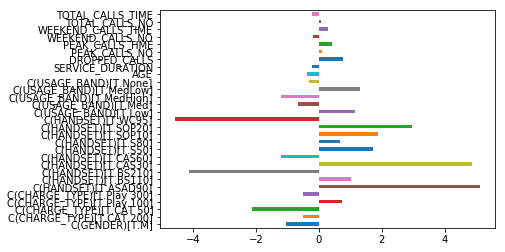

In [14]:
#from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = sm.Logit.from_formula("""CHURN ~ C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME + 1""", ds_tel_scaled_train)
#적합
scaled_log_result = scaled_log_model.fit(method='bfgs')
#설명변수 중요도
ds_log_scaled_coef  =pd.DataFrame({"Coef":scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
ds_log_scaled_coef.plot.barh(y = "Coef", legend = False)